# Comparison of Binary Classifiers

In [372]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt

# Task 3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve


%matplotlib inline

In [338]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [339]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [340]:
df['type'].unique()

array([1, 2, 3], dtype=int64)

In [341]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

#### Binary Classification
To turn the Seed data into a binary classification problem, I kept class 1 as the positive class and then turned types 2 and 3 into class 0. 

#### Misclassification
In some cases, the cost of false positives and false negatives may be roughly equivalent. In contrast, the cost of one type of error may be significantly higher in other cases. In this case, classifying different types of wheat as a false positive will result in a customer buying a wheat bag containing a mixture of the wrong type of wheat. However, a false negative would only result in grain not being added to the bag. A customer receiving a mix of wheat rather than the specific wheat they require could hurt their harvest and result in them not purchasing from that supplier again. Therefore reducing false positives is important in this case.


In [342]:
# Change type 2 to 0 and merge type 1 and 3 to make type 1

# create a list of features that need to be replaced
feature_list = ['type']

# create a dictionary with the values to be replaced and their corresponding replacements
replacement_dict = {1 : 1, 2: 0, 3 : 0}

# select the feature columns from the bank_df dataframe and replace their values using the replacement_dict
df[feature_list] = df[feature_list].replace(replacement_dict)

In [343]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

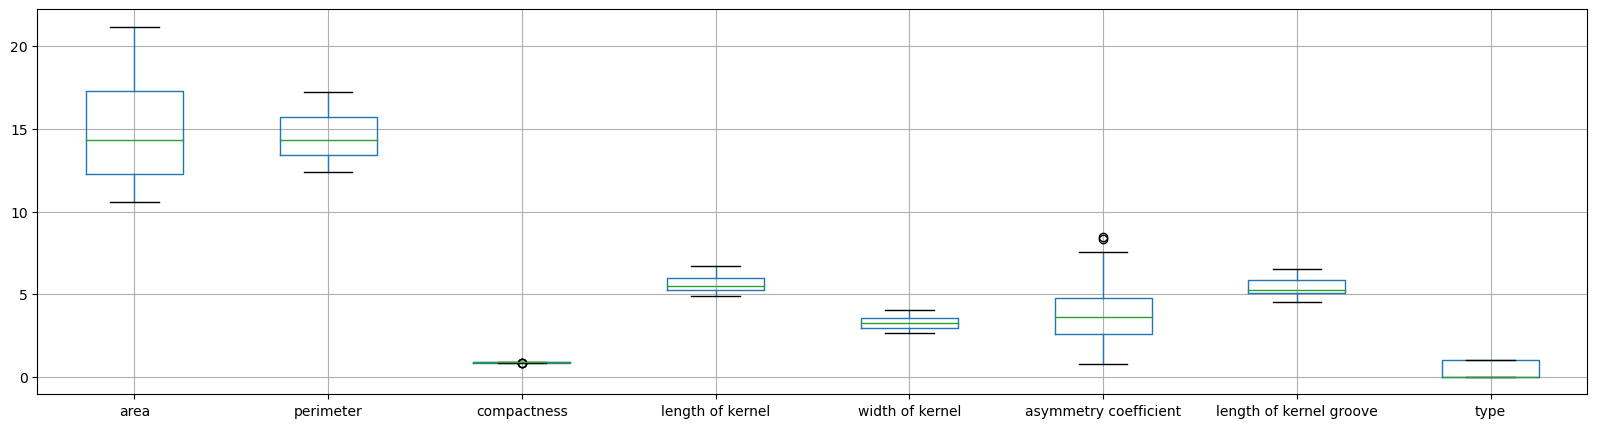

In [344]:
df.boxplot(figsize=(20,5))
plt.show()

In [345]:
names_all = list(df.drop(['type'], axis=1).columns)

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))


In [346]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [347]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [348]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [349]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [350]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.970:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'linear'}


In [351]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.929:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 20}


In [352]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [353]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [355]:
def evaluate_model_for_precision_recall_curve(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    mean_recall = np.linspace(0, 1, 100)
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute precision and recall values for different threshold levels
    _precision, _recall, _thresholds = precision_recall_curve(y_test, _probabilities)

    m_precision, m_recall, _ = precision_recall_curve(y_test, _predicted_values)
    
    # compute true positive rates for the values in the array mean_recall
    _tpr_transformed = np.array([np.interp(mean_recall, _recall[::-1], _precision[::-1])])
    
    # compute the area under the curve
    _auc = auc(_recall, _precision)
            
    return _accuracy, m_precision, m_recall, _f1_score[0], _tpr_transformed, _auc


In [356]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

# Store the outputs in a pandas dataframe
output_df = pd.DataFrame({
    'Accuracy': [SVM_accuracy, RF_accuracy],
    'Precision': [SVM_precision, RF_precision],
    'Recall': [SVM_recall, RF_recall],
    'F1 Score': [SVM_f1_score, RF_f1_score],
    'AUC': [SVM_auc, RF_auc]
}, index=['SVM', 'Random Forest'])

# Set the index name
output_df.index.name = 'Model'

# Transpose the dataframe to make the models the columns and the metrics the index
output_df = output_df.transpose()

In [357]:
output_df

Model,SVM,Random Forest
Accuracy,0.928571,0.904762
Precision,0.866667,0.857143
Recall,0.928571,0.857143
F1 Score,0.896552,0.857143
AUC,0.984694,0.969388


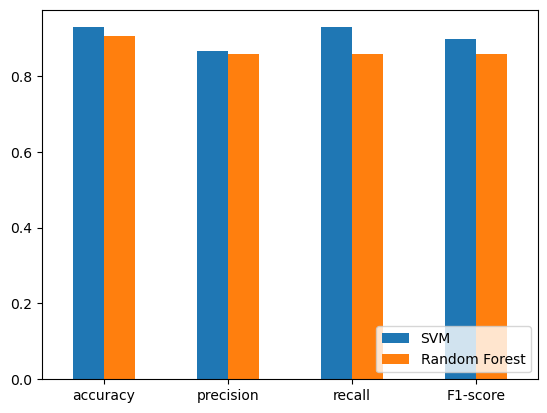

In [358]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

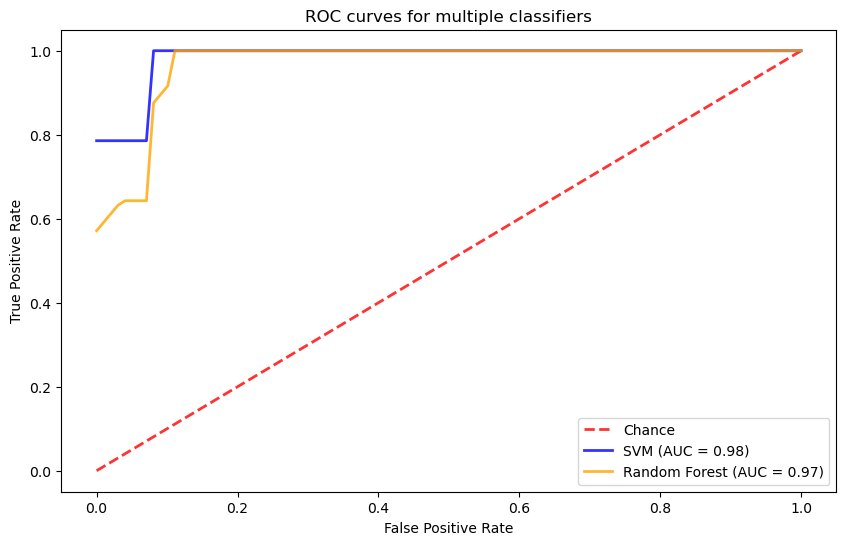

In [359]:
# Set the figure size
plt.figure(figsize=(10, 6))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

In [360]:
SVM_accuracy_PR, SVM_precision_PR, SVM_recall_PR, SVM_f1_score_PR, SVM_tpr_PR, SVM_auc_PR = evaluate_model_for_precision_recall_curve(X_test, y_test, SVM_best_model)
RF_accuracy_PR, RF_precision_PR, RF_recall_PR, RF_f1_score_PR, RF_tpr_PR, RF_auc_PR = evaluate_model_for_precision_recall_curve(X_test, y_test, RF_best_model)

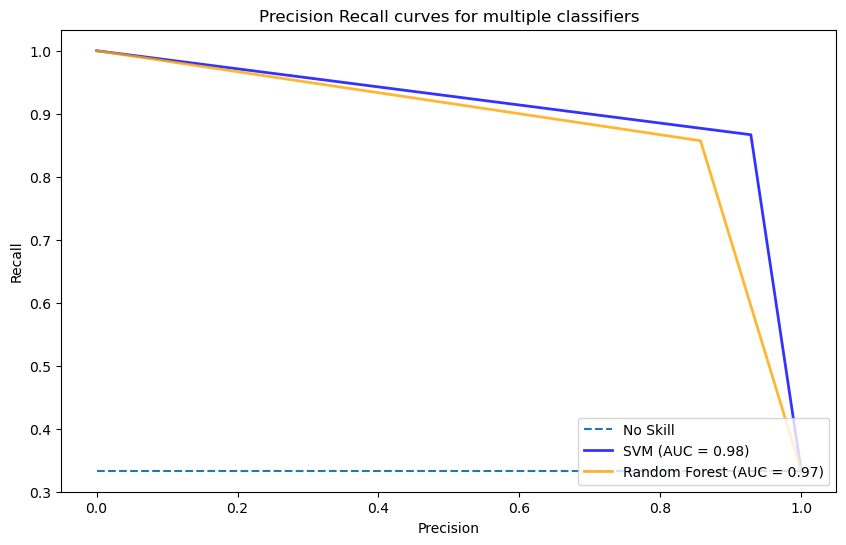

In [361]:
# Set the figure size
plt.figure(figsize=(10, 6))

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(SVM_recall_PR, SVM_precision_PR, lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(RF_recall_PR, RF_precision_PR, lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

#### Model Analysis
The SVM model outperformed the Random Forest model in all categories.

**Accuracy:** The SVM model had a slightly higher score of 0.928571 compared to 0.904762 for the Random Forest.

**Precision:** The SVM model had a score of 0.866667, indicating that when it predicted a positive outcome, it was correct approximately 87% of the time. The Random Forest model had a slightly lower precision score of 0.857143.

**Recall:** The SVM model scored 0.928571, indicating that it correctly identified approximately 93% of the positive cases in the dataset. The Random Forest model had a slightly lower recall score of 0.857143.

**F1 score:** Measures the balance between precision and recall, was higher for the SVM model at 0.896552 compared to 0.857143 for the Random Forest model.

**AUC (Area Under the Curve) score:** Measures the model's performance across all possible classification thresholds, was higher for the SVM model at 0.984694 compared to 0.969388 for the Random Forest model. This suggests that the SVM model is better at distinguishing between the positive and negative cases in the dataset.

While the Random Forest model performed reasonably well, the SVM model appeared to perform better.



### Task 3

In [362]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__metric': ['euclidean', 'manhattan']
}

search_knn = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search_knn.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search_knn.best_score_)
print("Best parameters: ", search_knn.best_params_)

knn_best_params = search_knn.best_params_
knn_best_model = search_knn.best_estimator_


Best CV score = 0.947:
Best parameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 5}


In [363]:
knn_accuracy, knn_precision, knn_recall, knn_f1_score, knn_tpr, knn_auc = evaluate_model(X_test, y_test, knn_best_model)

In [369]:
output_df['kNN'] = [knn_accuracy, knn_precision, knn_recall, knn_f1_score, knn_auc]

In [370]:
output_df

Model,SVM,Random Forest,kNN
Accuracy,0.928571,0.904762,0.904762
Precision,0.866667,0.857143,0.812500
Recall,0.928571,0.857143,0.928571
F1 Score,0.896552,0.857143,0.866667
AUC,0.984694,0.969388,0.988520


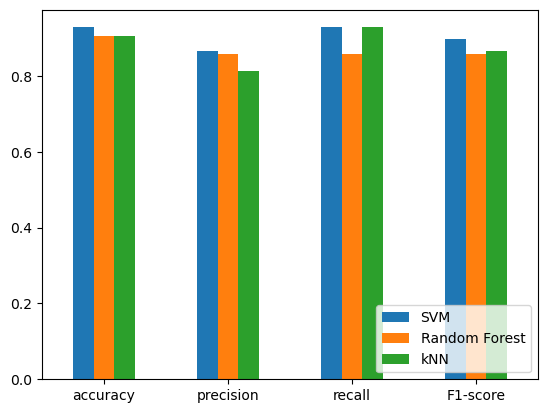

In [364]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([knn_accuracy, knn_precision, knn_recall, knn_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'kNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

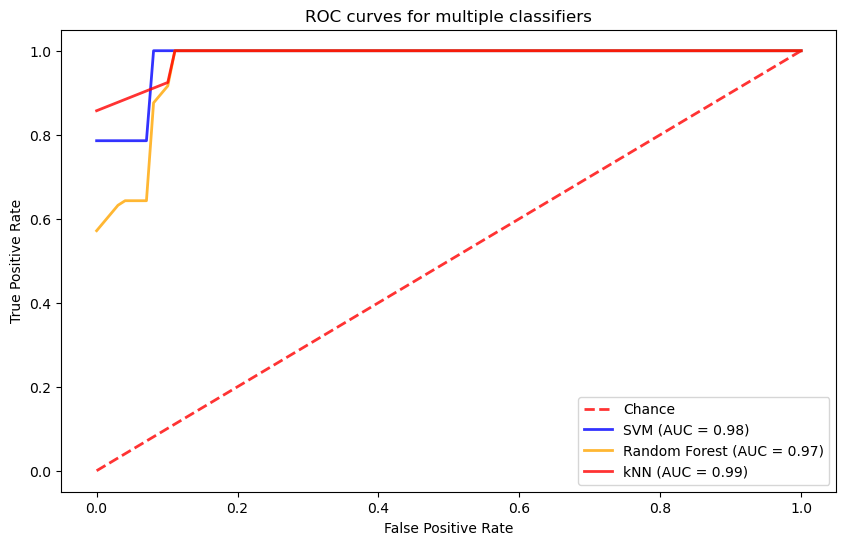

In [365]:
# Set the figure size
plt.figure(figsize=(10, 6))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, knn_tpr[0,:], lw=2, color='red', label='kNN (AUC = %0.2f)' % (knn_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

In [366]:
knn_accuracy_PR, knn_precision_PR, knn_recall_PR, knn_f1_score_PR, knn_tpr_PR, knn_auc_PR = evaluate_model_for_precision_recall_curve(X_test, y_test, knn_best_model)

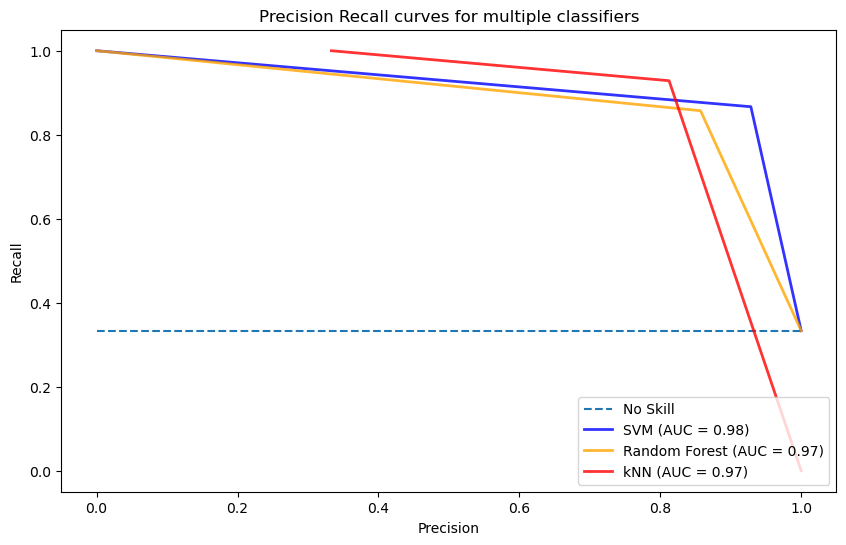

In [368]:
# Set the figure size
plt.figure(figsize=(10, 6))

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(SVM_recall_PR, SVM_precision_PR, lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(RF_recall_PR, RF_precision_PR, lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(knn_precision_PR, knn_recall_PR, lw=2, color='red', label='kNN (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### Conclusion

#### Comparison of the performance of SVM, Random Forest, and kNN models

**Accuracy:** The models have similar accuracy scores, with kNN and Random Forest at 0.904762 and SVM at 0.928571. Correctly classifying approximately 90% of the samples.

**Precision:** The SVM model had the highest precision score at 0.866667, meaning that when it predicted a positive outcome, it was correct approximately 87% of the time. The Random Forest model had a slightly lower precision score of 0.857143, and the kNN model had the lowest precision score at 0.812500.

**Recall:** The kNN and SVM models had the highest recall score at 0.928571, correctly identifying approximately 93% of the positive cases in the dataset. The Random Forest model had the lowest recall score of 0.857143.

**F1 Score:** The SVM model had the highest F1 score at 0.896552, followed by the kNN model at 0.866667 and the Random Forest model at 0.857143. The F1 score measures the balance between precision and recall, so a higher F1 score indicates that the model has a good balance between these metrics.

**AUC:** The kNN model had the highest AUC score at 0.988520, indicating that it is better at distinguishing between the positive and negative cases in the dataset. The SVM model had the second-highest AUC score at 0.984694, followed by the Random Forest model at 0.969388.

The SVM model performed slightly better than the other two models on this dataset, as it had the highest score in all cases except recall AUC, which had almost the same score as the highest.



## Train a Final Model


In [373]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model = pipe.fit(X, y)

In [374]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))